In [1]:
# Import libraries
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as ShapelyPolygon
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.metrics import accuracy_score
import os
import cv2

tf.keras.backend.clear_session()

2024-03-07 18:40:29.632084: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 18:40:29.632109: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 18:40:29.633078: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 18:40:29.638231: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-07 18:40:30.275100: W tensorflow/compiler/tf2

In [2]:
# Load Syntax data
with open('data/syntax/train/annotations/train.json') as f:
     syntax_train = pd.json_normalize(json.load(f), 'annotations')

with open('data/syntax/val/annotations/val.json') as f:     
     syntax_val = pd.json_normalize(json.load(f), 'annotations')

with open('data/syntax/test/annotations/test.json') as f:
     syntax_test = pd.json_normalize(json.load(f), 'annotations')

# Preview Syntax data
syntax_train.head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd,attributes.occluded
0,1,922,8,"[[382.0, 350.75, 380.25, 349.5, 378.75, 348.5,...",442.0,"[341.0, 232.0, 41.0, 119.0]",0,False
1,2,922,6,"[[199.25, 112.19, 207.12, 116.31, 211.38, 115....",786.0,"[199.25, 106.81, 98.0, 47.07]",0,False
2,3,922,5,"[[183.62, 136.5, 188.12, 134.88, 192.88, 130.1...",323.0,"[178.12, 112.0, 24.88, 25.25]",0,False
3,4,922,7,"[[295.5, 151.75, 297.5, 148.88, 300.25, 150.25...",567.0,"[293.0, 148.88, 52.5, 85.12]",0,False
4,5,793,16,"[[266.0, 316.5, 267.25, 317.75, 271.5, 314.5, ...",540.0,"[238.88, 227.12, 34.62, 90.63]",0,False


In [3]:
# Load Stenosis data
with open('data/stenosis/train/annotations/train.json') as f:
    stenosis_train = pd.json_normalize(json.load(f), 'annotations')

with open('data/stenosis/val/annotations/val.json') as f:
    stenosis_val = pd.json_normalize(json.load(f), 'annotations')

with open('data/stenosis/test/annotations/test.json') as f:
    stenosis_test = pd.json_normalize(json.load(f), 'annotations')

# Preview Stenosis data
stenosis_train.head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd,attributes.occluded
0,1,676,26,"[[278.0, 291.75, 286.75, 299.25, 289.5, 296.25...",708.0,"[278.0, 245.12, 42.75, 54.13]",0,False
1,2,960,26,"[[294.75, 315.0, 293.0, 322.0, 298.5, 322.5, 3...",457.0,"[293.0, 315.0, 68.0, 23.25]",0,False
2,3,960,26,"[[102.0, 172.25, 109.31, 179.25, 113.0, 175.75...",317.0,"[102.0, 157.38, 34.25, 21.87]",0,False
3,4,960,26,"[[87.69, 192.62, 96.69, 198.75, 95.81, 203.0, ...",388.0,"[84.38, 192.62, 12.31, 43.63]",0,False
4,5,99,26,"[[326.0, 232.62, 330.25, 231.38, 335.0, 239.75...",255.0,"[323.0, 221.25, 25.5, 26.13]",0,False


In [4]:
# Load label categories
with open('data/syntax/test/annotations/test.json') as f:
     categories= pd.json_normalize(json.load(f), 'categories')

# Show label categories
display(categories)

,id,name,supercategory
0,1,1,
1,2,2,
2,3,3,
3,4,4,
4,5,5,
5,6,6,
6,7,7,
7,8,8,
8,9,9,
9,10,9a,


In [5]:
# id, image_id, category_id, segmentation, area, and bbox are clearly valuable fields
# Review the other fields to confirm usefulness
print(syntax_train['iscrowd'].unique())
print(syntax_train['attributes.occluded'].unique())
print(stenosis_train['iscrowd'].unique())
print(stenosis_train['attributes.occluded'].unique())

[0]
[False]
[0]
[False]


In [6]:
# Drop area, bbox, iscrowd and attributed.occluded fields, which add no information
syntax_train.drop(['area','iscrowd','attributes.occluded'], axis=1, inplace=True)
syntax_val.drop(['area','iscrowd','attributes.occluded'], axis=1, inplace=True)
syntax_test.drop(['area','iscrowd','attributes.occluded'], axis=1, inplace=True)
stenosis_train.drop(['area','iscrowd','attributes.occluded'], axis=1, inplace=True)
stenosis_val.drop(['area','iscrowd','attributes.occluded'], axis=1, inplace=True)
stenosis_test.drop(['area','iscrowd','attributes.occluded'], axis=1, inplace=True)

# Check syntax_train data
stenosis_train.head()

,id,image_id,category_id,segmentation,bbox
0,1,676,26,"[[278.0, 291.75, 286.75, 299.25, 289.5, 296.25...","[278.0, 245.12, 42.75, 54.13]"
1,2,960,26,"[[294.75, 315.0, 293.0, 322.0, 298.5, 322.5, 3...","[293.0, 315.0, 68.0, 23.25]"
2,3,960,26,"[[102.0, 172.25, 109.31, 179.25, 113.0, 175.75...","[102.0, 157.38, 34.25, 21.87]"
3,4,960,26,"[[87.69, 192.62, 96.69, 198.75, 95.81, 203.0, ...","[84.38, 192.62, 12.31, 43.63]"
4,5,99,26,"[[326.0, 232.62, 330.25, 231.38, 335.0, 239.75...","[323.0, 221.25, 25.5, 26.13]"


In [7]:
# Add actual Syntax categories in and drop category_id
syntax_train = syntax_train.merge(categories[['id','name']], left_on='category_id', right_on='id', how='left').drop(['category_id', 'id_x', 'id_y'], axis=1)
syntax_train = syntax_train.rename(columns={'name': 'syntax_label'})
syntax_val = syntax_val.merge(categories[['id','name']], left_on='category_id', right_on='id', how='left').drop(['category_id', 'id_x', 'id_y'], axis=1)
syntax_val = syntax_val.rename(columns={'name': 'syntax_label'})
syntax_test = syntax_test.merge(categories[['id','name']], left_on='category_id', right_on='id', how='left').drop(['category_id', 'id_x', 'id_y'], axis=1)
syntax_test = syntax_test.rename(columns={'name': 'syntax_label'})
stenosis_train = stenosis_train.merge(categories[['id','name']], left_on='category_id', right_on='id', how='left').drop(['category_id', 'id_x', 'id_y'], axis=1)
stenosis_train = stenosis_train.rename(columns={'name': 'syntax_label'})
stenosis_val = stenosis_val.merge(categories[['id','name']], left_on='category_id', right_on='id', how='left').drop(['category_id', 'id_x', 'id_y'], axis=1)
stenosis_val = stenosis_val.rename(columns={'name': 'syntax_label'})
stenosis_test = stenosis_test.merge(categories[['id','name']], left_on='category_id', right_on='id', how='left').drop(['category_id', 'id_x', 'id_y'], axis=1)
stenosis_test = stenosis_test.rename(columns={'name': 'syntax_label'})

stenosis_train.head()

,image_id,segmentation,bbox,syntax_label
0,676,"[[278.0, 291.75, 286.75, 299.25, 289.5, 296.25...","[278.0, 245.12, 42.75, 54.13]",stenosis
1,960,"[[294.75, 315.0, 293.0, 322.0, 298.5, 322.5, 3...","[293.0, 315.0, 68.0, 23.25]",stenosis
2,960,"[[102.0, 172.25, 109.31, 179.25, 113.0, 175.75...","[102.0, 157.38, 34.25, 21.87]",stenosis
3,960,"[[87.69, 192.62, 96.69, 198.75, 95.81, 203.0, ...","[84.38, 192.62, 12.31, 43.63]",stenosis
4,99,"[[326.0, 232.62, 330.25, 231.38, 335.0, 239.75...","[323.0, 221.25, 25.5, 26.13]",stenosis


In [8]:
# Remove unneeded extra dimension for segmentation lists
syntax_train['segmentation'] = syntax_train['segmentation'].apply(lambda x: x[0])
syntax_val['segmentation'] = syntax_val['segmentation'].apply(lambda x: x[0])
syntax_test['segmentation'] = syntax_test['segmentation'].apply(lambda x: x[0])
stenosis_train['segmentation'] = stenosis_train['segmentation'].apply(lambda x: x[0])
stenosis_val['segmentation'] = stenosis_val['segmentation'].apply(lambda x: x[0])
stenosis_test['segmentation'] = stenosis_test['segmentation'].apply(lambda x: x[0])

stenosis_train.head()

,image_id,segmentation,bbox,syntax_label
0,676,"[278.0, 291.75, 286.75, 299.25, 289.5, 296.25,...","[278.0, 245.12, 42.75, 54.13]",stenosis
1,960,"[294.75, 315.0, 293.0, 322.0, 298.5, 322.5, 30...","[293.0, 315.0, 68.0, 23.25]",stenosis
2,960,"[102.0, 172.25, 109.31, 179.25, 113.0, 175.75,...","[102.0, 157.38, 34.25, 21.87]",stenosis
3,960,"[87.69, 192.62, 96.69, 198.75, 95.81, 203.0, 9...","[84.38, 192.62, 12.31, 43.63]",stenosis
4,99,"[326.0, 232.62, 330.25, 231.38, 335.0, 239.75,...","[323.0, 221.25, 25.5, 26.13]",stenosis


In [9]:
# Create a helper function to retrieve images

def get_image_path(dataset_name, image_id):
    """
    Construct an image path based on a dataset and a sample id.

    Args:
        dataset_name (string): name of the dataset
        id (integer): id of the sample

    Returns:
        image_path (string): the path of the image
    """
    image_folders = {
        'syntax_train' : 'data/syntax/train/images/',
        'syntax_val' : 'data/syntax/val/images/',
        'syntax_test' : 'data/syntax/test/images/',
        'stenosis_train' : 'data/stenosis/train/images/',
        'stenosis_val' : 'data/stenosis/val/images/',
        'stenosis_test' : 'data/stenosis/test/images'
    }

    image_path = image_folders[dataset_name] + str(image_id) + '.png'

    return image_path

In [10]:
# Create helper function to display five random images with annotations
# from a given dataset

def show_images(dataset, dataset_name, ids, ncols=5):
    """
    Display images with annotations for a given dataset.

    Args:
        dataset (Pandas DataFrame): the dataset
        dataset_name (string): the name of the dataset variable
        ids (numpy array): image ids to be shown
    """

    dataset = dataset.groupby('image_id').agg(list).reset_index()

    nrows = (len(ids)-1) // ncols + 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows*4))
    axes = axes.flatten()
    for ax, id, in zip(axes.flat, ids):
        image_path = get_image_path(dataset_name, id)
        image = Image.open(image_path)
        ax.imshow(image)
        segmentation_list = dataset.loc[dataset['image_id'] == id, 'segmentation'].iloc[0]
        label_list = dataset.loc[dataset['image_id'] == id, 'syntax_label'].iloc[0]
        for segmentation, label in zip(segmentation_list, label_list):
            poly_points = np.array(segmentation).reshape(-1,2)
            center = ShapelyPolygon(poly_points)
            centroid_x, centroid_y = center.centroid.x, center.centroid.y
            label_x, label_y = centroid_x - 60, centroid_y
            if label == 'stenosis':
                color='red'
            else:
                color='yellow'
                ax.plot([centroid_x, label_x+5], [centroid_y, label_y], color='yellow', linewidth=0.4) 
                ax.text(label_x, label_y, label, color='yellow', fontsize=8,
                    verticalalignment='center', horizontalalignment='right')
            poly = Polygon(poly_points,
                           edgecolor=color,
                           facecolor='none',
                           linewidth=0.4)            
            ax.add_patch(poly)    
        ax.set_title(f"image_id: {id}")
        ax.axis('off')

    fig.suptitle(dataset_name)
    plt.tight_layout()
    fig.subplots_adjust(top=1.25)
    plt.show()

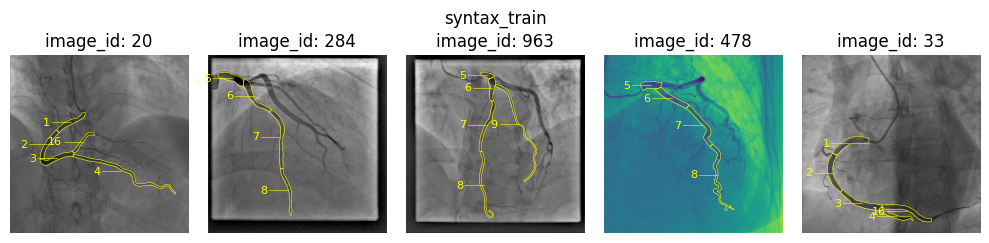

In [11]:
# Show five random segmentations for Syntax
ids = syntax_train['image_id'].sample(n=5, random_state=0)
show_images(syntax_train, 'syntax_train', ids)

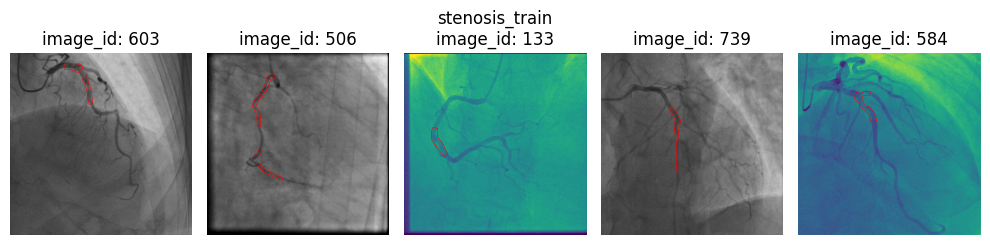

In [12]:
# Show five random segmenations for Stenosis
ids = stenosis_train['image_id'].sample(n=5, random_state=0)
show_images(stenosis_train, 'stenosis_train', ids)

In [33]:
def create_mask(segmentations, image_shape=(512, 512)):
    mask = np.zeros(image_shape, dtype=np.uint8)
    for segment in segmentations:
        x_coords = np.round(np.array(segment[::2]) * image_shape[1] / 512).astype(int)
        y_coords = np.round(np.array(segment[1::2]) * image_shape[0] / 512).astype(int)
        points = np.vstack((x_coords, y_coords)).T

        cv2.fillPoly(mask, [points], 255)

    mask = mask.astype(np.float32)
    return mask

In [66]:
def pad_to_square(image):
    # Determine the padding amounts
    height, width = image.shape[:2]
    diff = abs(height - width)
    pad_height = diff // 2 if height < width else 0
    pad_width = diff // 2 if width < height else 0

    # Apply padding to make the image square
    if len(image.shape) == 3:  # For 3D arrays, include channel dimension in padding
        padding = ((pad_height, diff - pad_height), (pad_width, diff - pad_width), (0, 0))
    else:  # For 2D arrays (grayscale images or masks), do not pad the non-existent channel dimension
        padding = ((pad_height, diff - pad_height), (pad_width, diff - pad_width))
    
    square_image = np.pad(image, padding, mode='constant', constant_values=0)
    return square_image

In [91]:
def load_data(path_to_data, label_table):
    image_ids = label_table.groupby(['image_id'])[['segmentation', 'bbox']].agg(list).index.to_list()
    segmentations = label_table.groupby(['image_id'])[['segmentation', 'bbox']].agg(list)

    images = []
    labels = []
    for image_id in image_ids:
        file_name = str(image_id) + '.png'
        file_path = os.path.join(path_to_data, file_name)
        image = load_img(file_path, color_mode='grayscale', target_size=(256,256))
        image_array = img_to_array(image)
        images.append(image_array)
        label = create_mask(segmentations.loc[image_id]['segmentation'], image_shape=(256, 256))
        labels.append(label)
        bboxes = segmentations.loc[image_id]['bbox']
        for bbox in bboxes:
            x, y, w, h = map(lambda v: int(v / 2), bbox) 
            x_max = x + w
            y_max = y + h
            cropped_image = image_array[y:y_max, x:x_max, :]
            square_image = pad_to_square(cropped_image)
            square_image_resized = np.resize(square_image, (256, 256))
            images.append(square_image_resized)
            cropped_label = label[y:y_max, x:x_max]
            square_label = pad_to_square(cropped_label)
            square_label_resized = np.resize(square_label, (256, 256))
            labels.append(square_label_resized)
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    images = images / 255.0
    labels = tf.convert_to_tensor(np.stack(labels, axis=0), dtype=tf.float32)
    
    return images, labels

In [92]:
stenosis_train.groupby(['image_id'])[['segmentation','bbox']].agg(list).head()

,segmentation,bbox
image_id,,
1,"[[388.25, 303.0, 385.5, 311.25, 382.5, 320.25,...","[[328.5, 297.0, 78.75, 140.75]]"
2,"[[253.62, 77.12, 258.75, 70.0, 252.12, 66.81, ...","[[225.38, 66.62, 33.37, 10.63], [235.75, 2.35,..."
3,"[[266.5, 173.62, 268.0, 184.12, 274.0, 193.25,...","[[266.5, 171.88, 75.75, 83.74]]"
4,"[[280.25, 176.0, 283.5, 196.75, 288.5, 216.88,...","[[269.25, 176.0, 68.5, 70.0]]"
5,"[[168.75, 87.12, 180.5, 88.56, 189.38, 92.12, ...","[[165.12, 73.56, 145.38, 66.69], [254.75, 154...."


In [93]:
X_train_stenosis, y_train_stenosis = load_data("data/stenosis/train/images/", stenosis_train)
X_val_stenosis, y_val_stenosis = load_data("data/stenosis/val/images/", stenosis_val)
X_test_stenosis, y_test_stenosis = load_data("data/stenosis/test/images/", stenosis_test)

ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [22]:
#Build dice loss function
def dice_loss(y_true, y_pred):
    smooth = 1e-6  # To avoid division by zero
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [23]:
def dice_bce_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

In [24]:
# Build Model Architecture
def conv_block(input_tensor, num_filters):
    """Build the convolutional block for U-Net."""
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)  # Added Batch Normalization
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)  # Added Batch Normalization
    return(x)

def encoder_block(input_tensor, num_filters):
    """Downsample and build encoder block."""
    x = conv_block(input_tensor, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    """Upsample and concatenate the feature map from encoder."""
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = layers.concatenate([x, concat_tensor], axis=-1)
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape=(256, 256, 1)):
    """Build U-Net model."""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)
    c4, p4 = encoder_block(p3, 256)

    # Bridge
    b = conv_block(p4, 512)

    # Decoder
    d1 = decoder_block(b, c4, 256)
    d2 = decoder_block(d1, c3, 128)
    d3 = decoder_block(d2, c2, 64)
    d4 = decoder_block(d3, c1, 32)

    # Output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

#Build U-Net model
tf.keras.backend.clear_session()
unet_model = build_unet()
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
unet_model.compile(optimizer=adam_optimizer, loss=dice_bce_loss, metrics=['accuracy'])

# Model summary
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['batch_normalization[0][0

In [25]:
history = unet_model.fit(
    x=X_train_stenosis,
    y=y_train_stenosis,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_stenosis, y_val_stenosis)
)

Epoch 1/10


2024-03-07 18:45:29.455993: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-07 18:45:29.525264: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-07 18:45:31.534951: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-07 18:45:33.241526: I external/local_xla/xla/service/service.cc:168] XLA service 0x78dd5d18d5b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-07 18:45:33.241546: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-07 18:45:33.244860: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709855133.304648  405031 device_compiler.

32/32 [==============================] - 32s 323ms/step - loss: -6.5820 - accuracy: 0.5479 - val_loss: 1.2572 - val_accuracy: 0.9851
Epoch 2/10
32/32 [==============================] - 6s 173ms/step - loss: -22.7949 - accuracy: 0.7019 - val_loss: 2.5051 - val_accuracy: 0.9906
Epoch 3/10
32/32 [==============================] - 6s 173ms/step - loss: -28.7097 - accuracy: 0.7373 - val_loss: 3.6536 - val_accuracy: 0.9906
Epoch 4/10
32/32 [==============================] - 6s 175ms/step - loss: -31.0149 - accuracy: 0.7748 - val_loss: 4.2728 - val_accuracy: 0.9895
Epoch 5/10
32/32 [==============================] - 6s 174ms/step - loss: -32.3938 - accuracy: 0.8059 - val_loss: 4.6165 - val_accuracy: 0.9856
Epoch 6/10
32/32 [==============================] - 6s 174ms/step - loss: -33.0152 - accuracy: 0.8290 - val_loss: 4.6477 - val_accuracy: 0.9830
Epoch 7/10
32/32 [==============================] - 6s 174ms/step - loss: -33.3853 - accuracy: 0.8497 - val_loss: 4.8980 - val_accuracy: 0.9806
Epo

In [26]:
y_pred_stenosis = unet_model.predict(X_test_stenosis)

10/10 [==============================] - 2s 154ms/step


In [27]:
predicted_masks = (y_pred_stenosis > 0.5).astype(np.uint8)
y_true_flat = y_test_stenosis.numpy().flatten()
y_pred_flat = predicted_masks.flatten()

test_accuracy = accuracy_score(y_true_flat, y_pred_flat)
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.9764284261067708


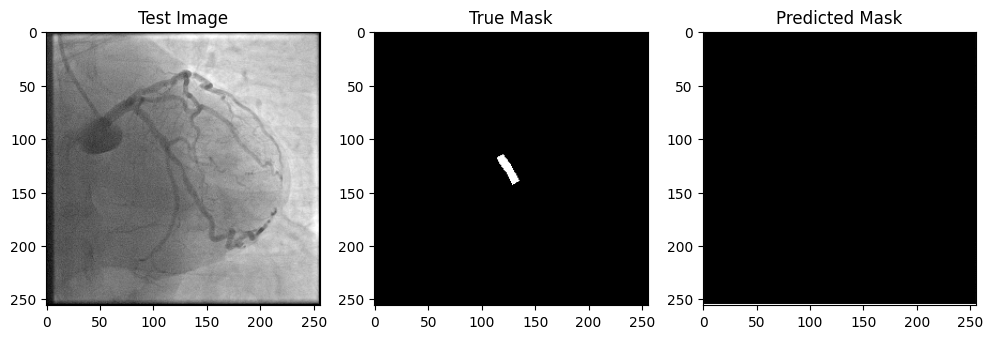

In [28]:
# Example: Visualize the first test image, its true mask, and the predicted mask
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(tf.squeeze(X_test_stenosis[0]), cmap='gray')  # Use tf.squeeze
plt.title('Test Image')
plt.subplot(1, 3, 2)
plt.imshow(tf.squeeze(y_test_stenosis[0]), cmap='gray')  # Use tf.squeeze
plt.title('True Mask')
plt.subplot(1, 3, 3)
plt.imshow(tf.squeeze(predicted_masks[0]), cmap='gray')  # Use tf.squeeze
plt.title('Predicted Mask')
plt.show()
